## Set-Up & Python Package Imports
Before we begin, let's import the python packages we need. We can add to this list as we wish.

In [1]:
# Imports and Set-Up
import numpy as np
import pandas as pd

# Inline Charts
%matplotlib inline
import matplotlib.pyplot as plt

# Cholesky Decomposition
from scipy.linalg import cholesky

# Newton-Raphson Solver for Yield-to-Maturity
from scipy.optimize import newton

# Noncentral Chi-Squared Distribution for Credit CIR Model
from scipy.stats import ncx2

# 1. AT1 CoCo Bonds: Mechanics, Triggers, and Pricing

## What is an AT1 CoCo Bond?

An **AT1 CoCo bond** (Additional Tier 1 Contingent Convertible bond) is a *hybrid capital instrument* issued by banks to strengthen regulatory capital. These bonds behave like debt under normal conditions but can **convert into equity or be partially/fully written down** if a regulatory capital threshold is breached.

- **Capital hierarchy:** Sits between senior debt and equity.  
- **Yield profile:** Typically offers higher yields than conventional bonds due to the risk of loss in stress scenarios.  
- **Embedded options:** Combines an **issuer call option** and a **regulatory credit contingent option**, which are central to valuation. 

<img src="images/AT1_Capital.png" alt="Additional Tier 1 Capital" width="600">
<p><em>Figure 1: Additional Tier 1 Capital (AT1)</em></p>

### Issuer Call Option

Most AT1 CoCos include an **issuer call option**, allowing the bank to redeem the bond after an initial lock-in period (often five years):

- **European call:** Single call date after the initial period.  
- **Bermudan call:** Multiple opportunities to redeem after the initial period.  
- **Purpose:** The issuer may call the bond if funding costs drop, optimizing capital efficiency.  

> **Pricing note:** The call option interacts with regulatory risk — a bond is less likely to be called if the CET1 ratio is near the trigger. Understanding this interaction is essential in CoCo valuation.

### Regulatory Credit Contingent Option

The **regulatory trigger** is typically based on the **Common Equity Tier 1 (CET1) ratio**. If the bank’s CET1 ratio falls below a set level (commonly 7%), the bond may:

- **Be written down** (partially or fully), or  
- **Convert into equity** at a predetermined conversion ratio or price.  

### One-Touch Down-and-In Analogy

This is conceptually equivalent to a **one-touch down-and-in barrier option**:

- **Underlying:** CET1 ratio of the bank  
- **Barrier:** Regulatory trigger level (e.g., 7%)  
- **Trigger:** The moment CET1 hits the barrier, the bond’s principal is either converted to equity or written down.  

> Imagine continuous monitoring: as soon as the CET1 ratio touches the threshold, the contingent option “activates.” This makes CoCo bonds path-dependent instruments, unlike vanilla bonds.

### Core Features

- Often **perpetual**, with no contractual maturity.  
- **Initial fixed coupons**, switching to floating + spread if not called.  
- **Issuer call schedule:** European or Bermudan, with a no-call period (typically 5 years).  
- **Regulatory trigger:** Usually a CET1 ratio of 7%.  
- **Conversion mechanics:** Deal-specific; can be partial/total write-down or equity conversion.  

> **Educational tip:** CoCos are highly bespoke — every deal has unique call schedules, coupon structures, and conversion mechanics. Always consult the term sheet for precise details.

<img src="images/CET1_Ratio.png" alt="Common Equity Tier 1 Ratio" width="600">
<p><em>Figure 2: Common Equity Tier 1 Ratio (CET1)</em></p>


## 2. CoCo Bond Definition

We define our CoCo bond with some simplifying assumptions to capture the **key interacting risks**—interest-rate, credit, and equity (capital adequacy)—without adding excessive complexity. This allows us to focus on the essential mechanics while keeping the model approachable.

### Case Study
For this worked Python example, we model a **10-year notional AT1 bond** with the following features:

- **Issuer call:** Single European call at **year 5**.  
- **Coupon:** Fixed for the life of this demo, to keep the example focused on conversion mechanics.  
- **Trigger observation:** The regulatory conversion trigger is observed at **coupon/payment dates** in the Monte Carlo simulation (discrete monitoring).  
- **Conversion mechanics:** On trigger, the bond can be either:  
  - `"write_down"` — partial or total principal loss, or  
  - `"convert_to_equity"` — converted at a pre-specified ratio or price.  

> **Interactive tip:** The parameters defined below can be changed to experiment with different term-sheet features and explore how call options, coupon structures, and conversion triggers affect the bond’s risk and pricing.


In [2]:
# ============================================================
# DEAL PARAMETERS
# ============================================================

NOTIONAL = 100.0             # Bond face value
COUPON_RATE = 0.05           # 5% annual coupon
COUPON_FREQ = 2              # Semiannual coupons (2 per year)
T_MATURITY = 10.0            # Bond maturity (years)
CALL_DATE = 5.0              # First call date
CALL_PRICE = 100.0           # Redemption price if called

# Coupons and Pay Times - Derived data needed later
COUPON_AMOUNT = COUPON_RATE / COUPON_FREQ * NOTIONAL
PAY_TIMES = np.arange(1/COUPON_FREQ, T_MATURITY + 1e-9, 1/COUPON_FREQ)

# Conversion settings
CONVERSION_TYPE = "write_down"  # "write_down" or "convert_to_equity"
WRITE_DOWN_RATIO = 1.0          # 1.0 = full write-down, 0 = no write-down

# Conversion to Equity (only relevant if CONVERSION_TYPE = "convert_to_equity")
INITIAL_SHARE_PRICE = 100.0     # Current share price
CONVERSION_PRICE = 50.0         # Price per share when converted
CONVERSION_RATIO = NOTIONAL / CONVERSION_PRICE  # Shares received per bond

# CET1 trigger (regulatory capital threshold)
CET1_TRIGGER_PERCENT = 0.07     # Trigger level (e.g., 7%)
CET1_CURRENT_PERCENT = 0.12     # Current CET1 (e.g., 12%)
EQ_BARRIER = CET1_TRIGGER_PERCENT / CET1_CURRENT_PERCENT  # normalized (~0.583)

## 3. Bond Pricing & Solving for the Implied Yield
Before introducing the CoCo-specific features, we implement the fixed bond pv method to calculate the **fixed bond price** using a simple discounting approach and the Newton-Raphson algorithm to solve for the implied yield.

- The fixed bond price is a baseline or benchmark price that **excludes all call options, conversion triggers, or write-down mechanics**.
- Its purpose is purely **educational**: to help you build intuition for how the bond’s cashflows are discounted to present value.  
- Once we introduce **callability and regulatory triggers**, we can compare the price against the benchmark vanilla price to understand the **value of these exotic features**.

In [3]:
# ============================================================
# FIXED BOND BENCHMARK: PRICE AND YIELD
# ============================================================

# Intial Guess for Yield to Maturity for Newton-Raphson Solver
YTM_INITIAL_GUESS = 0.03

# Compute baseline bond PV assuming no optionality - default ytm to initial guess of 3% when using to solve for ytm
def fixed_bond_pv(ytm):
    n_periods = np.arange(1, len(PAY_TIMES)+1)
    df = 1 / (1 + ytm / COUPON_FREQ) ** n_periods 
    pv_coupons = np.sum(COUPON_AMOUNT * df)
    pv_notional = NOTIONAL * df[-1]
    return pv_coupons + pv_notional

# Solve for yield-to-maturity given a target PV using Newton-Raphson
def solve_for_ytm(pv_target, coupon_amount=COUPON_AMOUNT, notional=NOTIONAL,
                  pay_times=PAY_TIMES, coupon_freq=COUPON_FREQ,
                  ytm_initial_guess=YTM_INITIAL_GUESS, tol=1e-8, max_iter=100):
    """
    Solve for yield-to-maturity given a target PV using Newton-Raphson.
    """
    y = ytm_initial_guess
    n_periods = np.arange(1, len(pay_times) + 1)

    for i in range(max_iter):
        # --- Discount factors ---
        df = 1 / (1 + y / coupon_freq) ** n_periods

        # --- PV at current guess ---
        pv = np.sum(coupon_amount * df) + notional * df[-1]

        # --- Derivative dPV/dy ---
        dPV_dy = -np.sum(n_periods * coupon_amount * df / coupon_freq) - n_periods[-1] * notional * df[-1] / coupon_freq

        # --- Newton-Raphson update ---
        if dPV_dy == 0:
            raise ValueError("Derivative is zero, cannot continue")
        y_new = y - (pv - pv_target) / dPV_dy

        # --- Return Solution if found ---
        if abs(y_new - y) < tol:
            return y_new
        
        y = y_new

    raise RuntimeError("Newton-Raphson did not converge")


def fixed_bond_cashflows(ytm):

    print(f"\nFixed Bond Cash Flows")
    print(f"---------------------\n")
    
    # generate dataframe for cash flow table
    df = pd.DataFrame({'Time': PAY_TIMES})
    
    df['Coupon'] = COUPON_AMOUNT
    df['Principal'] = 0.0
    
    df.loc[df.index[-1], 'Principal'] = NOTIONAL  # last payment includes principal
    df['Cashflow'] = df['Coupon'] + df['Principal']
    
    n_periods = np.arange(1, len(PAY_TIMES)+1)
    df['DiscountFactor'] = 1 / (1 + ytm / COUPON_FREQ) ** n_periods 
    df['PV'] = df['Cashflow'] * df['DiscountFactor']

    # Bond price = sum of discounted cash flows
    bond_price = df['PV'].sum()

    df_display = df[['Time', 'Cashflow', 'DiscountFactor', 'PV']]
    print(df_display)
    print(f"\nFixed bond price (no special features): {bond_price:.2f}")


## 4. Modeling Approach and Pricing Summary

To price our AT1 CoCo bond, we capture the three key interacting risks:

1. **Interest rate risk** — affects discounting of future cashflows.  
2. **Credit risk** — captures the probability of default or write-down.  
3. **Equity / capital adequacy risk** — modeled via **CET1 levels**, using equity as a proxy for simplicity.

We simulate these risk factors **jointly in a Monte Carlo framework**, introducing correlations using correlated random v.  

## Models

In this notebook, we simulate the three main risk factors driving AT1 CoCo bond pricing:

4.1 **Interest Rates** — Extended Hull-White (HW) Model  
4.2 **Credit / Hazard Rate** — Cox-Ingersoll-Ross (CIR) Model  
4.3 **CET1 / Equity Proxy** — Geometric Brownian Motion (GBM)

---

### 4.1 Interest Rates — Extended Hull-White (HW) Model

We use the **Extended Hull-White model**, which is a **one-factor mean-reverting short-rate model**:

$$
dr_t = [\theta(t) - a \, r_t] \, dt + \sigma \, dW_t
$$

- $r_t$ — instantaneous short rate  
- $a$ — mean-reversion speed  
- $\sigma$ — short-rate volatility  
- $\theta(t)$ — deterministic drift (shift) used to fit the **initial yield curve**  
- $dW_t$ — Wiener process  

**Calibration approach (pre-done in this notebook):**  
- $\sigma$ is calibrated to **ATM swaption volatilities**  
- $\theta(t)$ is calibrated to **match the initial yield curve shape**  

> **Note:** While the HW model captures ATM volatilities well, it does **not capture volatility skew**.
> For skew modeling, one could incorporate a **two-factor HW model**, **SABR model** or **LMM with displaced diffusion** to capture skew effects more accurately.
---

### 4.2 Credit Risk — Cox-Ingersoll-Ross (CIR) Model

The hazard rate $\lambda_t$ is modeled using CIR to ensure **strictly positive default intensities**:

$$
d\lambda_t = k (\theta - \lambda_t) \, dt + \sigma \sqrt{\lambda_t} \, dW_t
$$

- $\lambda_t$ — default intensity / hazard rate  
- $k$ — speed of mean reversion  
- $\theta$ — long-term mean hazard rate  
- $\sigma$ — volatility  
- $dW_t$ — Wiener process  

**Calibration approach:**  
- Fit $k$, $\theta$, and $\sigma$ to **market-implied hazard rates**, which are derived from a **deterministic CDS curve** built separately.  
- Ideally, $\sigma$ would be calibrated to **credit option volatilities**. However, these options are **rare and illiquid**, except for some **sovereigns or large corporates**.  
- When market option data is unavailable, we use **historical credit spread volatility** as a proxy.  

> **Key point:** Calibration must be performed **after building the CDS-implied hazard curve**, because the model parameters are adjusted to reproduce **both the level and the dynamics of credit risk**.

---

### 4.3 CET1 / Equity Proxy — Geometric Brownian Motion (GBM)

CET1 or equity levels are simulated using GBM:

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

- $S_t$ — CET1 or equity proxy  
- $\mu$ — drift term  
- $\sigma$ — volatility  
- $dW_t$ — Wiener process  

**Calibration approach:**  
- $\sigma$ can be taken from **historical equity volatility** or **regulatory estimates**  
- $\mu$ reflects expected CET1 growth assumptions  

---

### 💡 Key Notes

- All three models are **pre-calibrated** in this notebook for simplicity and to let you explore **CoCo bond mechanics**.  
- Correlations between the three factors are introduced via **Cholesky decomposition** in Monte Carlo simulation.  
- HW model is analytically tractable, CIR ensures positive default probabilities, and GBM provides a simple stochastic CET1 proxy.


## 5. Model Setup

We simulate the three main risk factors for our AT1 CoCo bond:

1. **Interest Rates:** Extended Hull-White (HW) model  
2. **Credit / Hazard Rate:** Cox-Ingersoll-Ross (CIR) model  
3. **CET1 / Equity Proxy:** Geometric Brownian Motion (GBM)

> **Note:** In this notebook, the models are **pre-calibrated to market data**, and we have **hard-coded the calibrated parameters**.  
> This allows you to focus on **bond mechanics, triggers, and Monte Carlo pricing** without getting bogged down in full calibration routines.  
> You can still interactively tweak parameters to explore their effect on bond valuation.

The HW model here is set up with **mean-reversion, volatility, and shift parameters**, consistent with standard ATM calibration to the yield curve and swaption volatilities. CIR ensures strictly positive hazard rates, and GBM models CET1/equity as a stochastic path correlated with rates and credit.


In [4]:
# ============================================================
# MODEL PARAMETERS
# ============================================================

# --- Hull–White Interest Rate Model (Short rate) ---
# dr = a*(r_mean - r)*dt + sigma*dW_r
# Captures mean-reverting dynamics of the short-term rate.
HW_R0 = 0.05       # Starting rate (5%)
HW_A = 0.03        # Mean reversion speed
HW_SIGMA = 0.01    # Volatility of the short rate

# --- CIR Model (Hazard rate / credit intensity) ---
# dh = k*(theta - h)*dt + sigma*sqrt(h)*dW_h
# Ensures hazard rate remains non-negative.
CIR_L0 = 0.015     # Initial hazard rate (1.5%)
CIR_K = 0.3        # Mean reversion speed
CIR_THETA = 0.02   # Long-term mean hazard rate
CIR_SIGMA = 0.005  # Volatility of hazard rate

# --- GBM for Equity (CET1 proxy) ---
# dS/S = mu*dt + sigma*dW_e
# Tracks normalized CET1 ratio as an equity-like process.
EQ_SPOT = 1.0
EQ_MU = 0.00       # Drift (expected growth of CET1)
EQ_SIGMA = 0.15    # Volatility of CET1 proxy

# Derived GBM equity drift term
EQ_DRIFT = EQ_MU - 0.5 * EQ_SIGMA ** 2

## 6. Monte Carlo Simulation and Correlations

In reality, our three risk factors — **interest rates**, **credit spreads (hazard rates)**, and **equity prices** — do not evolve independently.  
Macroeconomic conditions, liquidity cycles, and risk sentiment create **systematic co-movements** across these drivers.

To capture this, we introduce **correlation** between the Brownian shocks driving each process:
- $W_r$ — for the **interest rate** process (Extended Hull–White)
- $W_\lambda$ — for the **hazard rate** process (CIR)
- $W_S$ — for the **equity** process (GBM)

We define a **correlation matrix** $\rho$ such that:

$$
\rho =
\begin{bmatrix}
1 & \rho_{r\lambda} & \rho_{rS} \\
\rho_{r\lambda} & 1 & \rho_{\lambda S} \\
\rho_{rS} & \rho_{\lambda S} & 1
\end{bmatrix}
$$

Typical intuition:
- **$\rho_{r\lambda} > 0$** — rising rates often coincide with tighter credit spreads (improving credit).
- **$\rho_{rS} > 0$** — equities and rates both respond to growth expectations.
- **$\rho_{\lambda S} < 0$** — credit stress and falling equities often occur together.

To simulate correlated paths, we use **Cholesky decomposition**:
$$
\Sigma = L L^\top
$$
where \( L \) is a lower-triangular matrix.  
We then transform a vector of **independent normal randoms** \( Z \sim N(0, I) \) into **correlated shocks**:

$$
\epsilon = L Z
$$

This ensures our Monte Carlo paths correctly reflect **cross-factor dependencies**.

> **Note:** Correlations play a major role in joint tail events — for example, when rising rates simultaneously stress both equity and credit components of a CoCo bond.


In [5]:
# ============================================================
# MONTE CARLO PARAMETERS
# ============================================================
DT = 1 / 12        # Monthly time step
T_STEPS = int(T_MATURITY / DT)
N_PATHS = 10000
ANTITHETIC = False # Use antithetic variance reduction

np.random.seed(42) # # Set seed for reproducible random numbers

# ============================================================
# CORRELATION PARAMETERS
# ============================================================

# --- Correlations between Risk Factors ---
RHO_R_H = 0.5      # Rate ↔ Hazard (credit/IR correlation)
RHO_R_E = 0.3      # Rate ↔ Equity (macro link)
RHO_H_E = 0.3      # Hazard ↔ Equity (credit-equity link)

CHOLESKY = np.linalg.cholesky(np.array([
    [1.0, RHO_R_H, RHO_R_E],
    [RHO_R_H, 1.0, RHO_H_E],
    [RHO_R_E, RHO_H_E, 1.0]
]))


## 7. Monte Carlo Simulation of Risk Factors (discretization)

We simulate joint paths for the three risk drivers — interest rates ($r_t$), hazard rates ($\lambda_t$), and equity / CET1 proxy ($S_t$) — using Monte Carlo. Below we explain the discretization used to turn continuous SDEs into stepwise updates suitable for simulation.

---

### 7.1 Monte Carlo Outline

Under the risk-neutral measure $\mathbb{Q}$ we estimate the price as the discounted expectation of payoffs:
$$
\text{Price} \approx \frac{1}{N}\sum_{i=1}^{N} \exp\!\Big(-\sum_{j} r_{t_j}^{(i)}\Delta t\Big)\,\text{Payoff}^{(i)}
$$
where each $(i)$ denotes a simulated path.

---

### 7.2 Discretization

We discretize time with step $\Delta t$ and draw standard normal shocks at each step. Correlated shocks are produced via Cholesky: if $Z\sim\mathcal{N}(0,I)$ then
$$
\epsilon = L\,Z
$$
where $L$ is the lower-triangular Cholesky factor of the correlation matrix. The vector $\epsilon=(\epsilon_r,\epsilon_\lambda,\epsilon_S)$ provides correlated normals for the three drivers.

**Extended Hull–White (short rate)**  
Continuous SDE (extended HW):
$$
dr_t = [\theta(t) - a\,r_t]\,dt + \sigma\,dW_t.
$$
Discrete (Euler-Maruyama) step for MC:
$$
r_{t+\Delta t} = r_t + [\theta(t) - a\,r_t]\,\Delta t + \sigma\sqrt{\Delta t}\,\epsilon_r.
$$

**CIR (hazard / default intensity)**  
The CIR process remains strictly positive, making it ideal for default/hazard modeling.  

Continuous SDE:
$$
d\lambda_t = k(\theta - \lambda_t)\,dt + \sigma\sqrt{\lambda_t}\,dW_t.
$$
Discrete (Euler with square-root term and non-negativity truncation):
$$
\lambda_{t+\Delta t} = \lambda_t + k(\theta - \lambda_t)\,\Delta t + \sigma\sqrt{\max(\lambda_t,0)}\sqrt{\Delta t}\,\epsilon_\lambda,
$$
then enforce $\lambda_{t+\Delta t}\ge0$ (e.g. truncation to zero).

**GBM (equity / CET1 proxy)**  
Continuous SDE:
$$
dS_t = \mu S_t\,dt + \sigma_S S_t\,dW_t.
$$
Exact discrete update (log-Euler, exact over the step for GBM):
$$
S_{t+\Delta t} = S_t\exp\Big((\mu - \tfrac{1}{2}\sigma_S^2)\Delta t + \sigma_S\sqrt{\Delta t}\,\epsilon_S\Big).
$$

---

### 7.3 Correlated draws and implementation notes

1. Draw independent normals $Z\sim\mathcal{N}(0,I)$ of dimension 3.  
2. Form correlated shocks $\epsilon = L Z$ (so each step uses the same $L$).  
3. Use $\epsilon_r,\epsilon_\lambda,\epsilon_S$ in the discrete updates above.

**Variance reduction:** Antithetic sampling is easy to implement: mirror draws by using $-Z$ to form paired paths.

---

### 7.4 Numerical Accuracy & Exact Simulation

- **Euler–Maruyama** (used above) is the standard, simple approach and is usually adequate for pricing where model risk dominates discretization error.  
- **Improved / exact alternatives** exist and may be preferable if you need higher accuracy:  
  - **Hull–White:** exact Gaussian sampling of $r_t$ is possible (sample mean and variance analytically) rather than Euler steps.  
  - **CIR:** exact sampling via the non-central chi-square distribution is available for the CIR process (avoids square-root discretization bias).  
  - **GBM:** the log-Euler exact update is already exact for GBM over a time step.  

#### 7.4.1 Exact Hull–White Sampling:
For the Hull–White short-rate process, we can also use **exact Gaussian sampling** rather than a simple Euler discretization.  
Since the SDE is **linear in \( r_t \)**, its conditional distribution is known in closed form:  
$$
r_{t+\Delta t} = r_t e^{-a\Delta t} + \theta(t)(1 - e^{-a\Delta t}) + \sqrt{\frac{\sigma^2}{2a}(1 - e^{-2a\Delta t})}\,\epsilon_r,
$$
where $ \epsilon_r \sim \mathcal{N}(0,1) $.  
This approach eliminates **drift bias** and ensures **faster convergence** in the Monte Carlo simulation while maintaining analytical consistency with the model calibration.

#### 7.4.2 Exact CIR Sampling
Over a time step $\Delta t$, the conditional distribution of $\lambda_{t+\Delta t}$ given $\lambda_t$ is **non-central chi- square**:
$$
\lambda_{t+\Delta t} = \frac{\sigma^2 (1 - e^{-k \Delta t})}{4 k} \, \chi'^2_d(\text{nc})
$$
where $d = \frac{4 k \theta}{\sigma^2}$ and the non-centrality parameter is 
$$
\text{nc} = \frac{4 k e^{-k \Delta t} \lambda_t}{\sigma^2 (1 - e^{-k \Delta t})}.
$$

Sample $Y \sim \chi'^2_d(\text{nc})$ and scale to get $\lambda_{t+\Delta t}$ giving,
$$
\lambda_{t+\Delta t} = \frac{\sigma^2 (1 - e^{-k \Delta t})}{4 k} Y
$$

This produces an **exactly distributed hazard rate**, avoiding negative rates and discretization errors common in Euler approximations.

In this notebook we use the Euler-style discretization for consistency and pedagogical clarity, but you can replace with exact samplers for HW / CIR if you require higher numerical fidelity.

---

### 7.5 What we do with the simulated paths

For each simulated path we will:
- compute discount factors (from the simulated short rates) to PV cashflows,
- track the hazard path to compute survival/default probabilities and apply write-down/default logic,
- track the CET1/equity path to evaluate conversion triggers,
- and evaluate issuer call decisions using the forward rates/discounting from the same simulated path.

All three drivers are correlated via the Cholesky-based shocks, so joint tail events are captured naturally by the simulation.


In [6]:
# ============================================================
# SIMULATION FUNCTION
# ============================================================

def simulate_paths(num_paths=N_PATHS, antithetic=ANTITHETIC):
    """
    Simulate correlated Hull–White, CIR, and GBM paths.
    If antithetic is True, generate half the paths and mirror them after.
    Returns full array of N_PATHS x (T_STEPS+1).
    """
    base_paths = num_paths // 2 if antithetic else num_paths

    rates = np.zeros((base_paths, T_STEPS + 1))
    hazards = np.zeros((base_paths, T_STEPS + 1))
    equities = np.zeros((base_paths, T_STEPS + 1))

    rates[:, 0] = HW_R0
    hazards[:, 0] = CIR_L0
    equities[:, 0] = EQ_SPOT
    
    sqrt_dt = np.sqrt(DT)
    exp_a_dt = np.exp(-HW_A * DT)

    for t in range(T_STEPS):
        z = np.random.normal(size=(base_paths, 3))
        dW = z @ CHOLESKY.T

        # --- Hull–White (mean-reverting short rate) ---
        # ==============================================
        
        # --- Euler-Mayurama (Approximate) ---
        # dr = HW_A * (HW_R0 - rates[:, t]) * DT + HW_SIGMA * dW[:, 0] * sqrt_dt
        # rates[:, t + 1] = rates[:, t] + dr
        
        # --- Exact Discretization ---
        mean_r = HW_R0 * (1 - exp_a_dt) + rates[:, t] * exp_a_dt
        var_r = (HW_SIGMA**2) * (1 - np.exp(-2 * HW_A * DT)) / (2 * HW_A)
        rates[:, t + 1] = mean_r + np.sqrt(var_r) * dW[:, 0]
        
        # --- CIR (hazard rate, positive process) ---
        # ==============================================
        
        # --- Euler-Mayurama (Approximate) ---
        # sqrt_h = np.sqrt(np.maximum(hazards[:, t], 0))
        # dh = CIR_K * (CIR_THETA - hazards[:, t]) * DT + CIR_SIGMA * sqrt_h * dW[:, 1] * sqrt_dt
        # hazards[:, t + 1] = np.maximum(hazards[:, t] + dh, 0)

        # --- Exact discretization using noncentral chi-squared distribution ---
        c = (CIR_SIGMA**2 * (1 - np.exp(-CIR_K * DT))) / (4 * CIR_K)
        d = 4 * CIR_K * CIR_THETA / CIR_SIGMA**2
        λ = (4 * CIR_K * np.exp(-CIR_K * DT) * hazards[:, t]) / (CIR_SIGMA**2 * (1 - np.exp(-CIR_K * DT)))
        hazards[:, t + 1] = c * ncx2.rvs(d, λ) # noncentral chi-squared (ncx2) random variates (rvs)
        
        # --- GBM (Equity for CET1 proxy) ---
        # ==============================================
        
        dE = (EQ_MU - 0.5 * EQ_SIGMA**2) * DT + EQ_SIGMA * sqrt_dt * dW[:, 2]
        equities[:, t + 1] = equities[:, t] * np.exp(dE)

    # Antithetic mirroring
    if antithetic:
        rates = np.vstack([rates, rates[:, ::-1]])
        hazards = np.vstack([hazards, hazards[:, ::-1]])
        equities = np.vstack([equities, 2*EQ_SPOT - equities[:, ::-1]])  # mirror around initial equity

    return rates, hazards, equities

## 8. Monte Carlo Pricing Function for AT1 CoCo Bonds

The function below computes the present value (PV) of a single Monte Carlo path for an AT1 CoCo bond, taking into account:

- **Discounting:** using the simulated interest rate path.
- **Survival:** accounting for default risk via the hazard rate path.
- **Coupons:** paid at scheduled times, discounted and survival-adjusted.
- **Issuer call:** optional redemption at a pre-specified call date, if economically beneficial.
- **Regulatory conversion:** triggers if the CET1 proxy (equity) falls below the barrier, with either:
  - **Write-down** of principal, or  
  - **Conversion into equity** at a predetermined ratio.

This function is applied path-by-path in a Monte Carlo framework and then averaged to produce the bond’s expected value.

In [7]:
# ============================================================
# PRICING FUNCTION
# ============================================================

def price_path(rates, hazard, equity, dt, coupon, notional, pay_times,
               call_date, call_price, eq_barrier, conv_ratio, conv_type, write_down_ratio):
    """Compute discounted PV for a single path, accounting for call and conversion events."""

    df_path = np.exp(-np.cumsum((rates[:-1] + rates[1:]) / 2 * dt))
    surv_path = np.exp(-np.cumsum((hazard[:-1] + hazard[1:]) / 2 * dt))
    n_pay = len(pay_times)

    pv = 0.0
    called = False
    converted = False

    for i, t in enumerate(pay_times):
        pv += coupon * surv_path[i] * df_path[i]

        if abs(t - call_date) < 1e-9:
            continuation_value = sum(coupon * surv_path[j] * df_path[j] for j in range(i + 1, n_pay))
            continuation_value += notional * surv_path[-1] * df_path[-1]
            if continuation_value > call_price:
                pv += call_price * surv_path[i] * df_path[i]
                called = True
                return pv, called, converted

        if equity[i] < eq_barrier:
            converted = True
            if conv_type == "write_down":
                pv += notional * (1 - write_down_ratio) * surv_path[i] * df_path[i]
            elif conv_type == "convert_to_equity":
                share_price = INITIAL_SHARE_PRICE * equity[i]
                pv += conv_ratio * share_price * surv_path[i] * df_path[i]
            return pv, called, converted

    pv += notional * surv_path[-1] * df_path[-1]
    return pv, called, converted

## 9. Monte Carlo Diagnostics & Charts

Once we have simulated paths and can price a single path, we can:

1. **Run the full Monte Carlo** to compute the expected bond PV across many paths.
2. **Visualize risk factor paths** (interest rates, hazard rates, equity/CET1 proxy).
3. **Analyze events** (call, conversion, alive) and convergence of the Monte Carlo estimate.

The following code is structured in three parts:

- **Diagnostics Functions**: Summarize events and show Monte Carlo convergence.
- **Visualization Functions**: Plot sample paths for interest rates, hazard rates, and CET1 proxy.
- **Simulation Driver**: Loop over paths, compute PV using the `price_path` function, and optionally show diagnostics.


In [8]:
# ============================================================
# DIAGNOSTICS AND VISUALIZATION
# ============================================================

def run_diagnostics(df, convergence_data):
    """Print event breakdown and convergence diagnostics."""
    summary = df.groupby('Event')['PV'].agg(['count', 'mean', 'std'])
    summary['Probability'] = summary['count'] / len(df)
    print("\nEvent Summary:")
    print(summary[['count', 'Probability', 'mean', 'std']].round(3))

    if convergence_data:
        conv_df = pd.DataFrame(convergence_data, columns=['Paths', 'MeanPV'])
        print("\nConvergence Table:")
        print(conv_df.to_string(index=False))

        plt.figure(figsize=(10, 5))
        plt.plot(conv_df['Paths'], conv_df['MeanPV'], marker='o')
        plt.title("Monte Carlo Convergence (Mean PV vs Paths)")
        plt.xlabel("Paths Simulated")
        plt.ylabel("Mean PV")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

def plot_curves(rates, hazards, equities, num_paths_plot=30):
    """
    Plot Monte Carlo paths for interest rates, hazard rates, and CET1 proxy
    as three separate figures for clarity.
    """
    num_paths_plot = min(num_paths_plot, rates.shape[0])
    num_steps = rates.shape[1]
    time_grid = np.linspace(0, T_MATURITY, num_steps)

    # --- Hull–White Short Rate Paths ---
    plt.figure(figsize=(10, 4))
    for i in range(num_paths_plot):
        plt.plot(time_grid, rates[i, :], alpha=0.3, linewidth=0.8)
    plt.title("Interest Rate Paths (Hull–White Model)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Short Rate")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- CIR Hazard Rate Paths ---
    plt.figure(figsize=(10, 4))
    for i in range(num_paths_plot):
        plt.plot(time_grid, hazards[i, :], alpha=0.3, linewidth=0.8, color='orange')
    plt.title("Hazard Rate Paths (CIR Model)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Hazard Rate")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- CET1 Proxy (Equity GBM) Paths ---
    plt.figure(figsize=(10, 4))
    for i in range(num_paths_plot):
        plt.plot(time_grid, equities[i, :], alpha=0.3, linewidth=0.8, color='green')
    plt.axhline(EQ_BARRIER, color='red', linestyle='--', label='Conversion Barrier')
    plt.title("Equity CET1 Proxy Paths (GBM)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Equity Level (Normalized)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

## 10. Running Monte Carlo Simulations

This function orchestrates the Monte Carlo simulation:

1. **Simulate correlated paths** for interest rates (HW), hazard rates (CIR), and equity (GBM).  
2. **Price each path** using the `price_path` function, which accounts for coupons, call, and regulatory conversion.  
3. **Track statistics** such as average PV, event frequency, and optional convergence data.  
4. **Display diagnostics** and visualizations for paths and events.


In [9]:
# ============================================================
# RUNNING MONTE CARLO SIMULAITONS
# ============================================================

def run_simulation(num_paths=N_PATHS, use_antithetic=ANTITHETIC, show_diagnostics=True, conv_step=1000):
    """
    Full Monte Carlo run with diagnostics.
    """
    dt = DT
    coupon = COUPON_RATE / COUPON_FREQ * NOTIONAL
    pay_times = np.arange(1 / COUPON_FREQ, T_MATURITY + 1e-9, 1 / COUPON_FREQ)

    rates, hazards, equities = simulate_paths(num_paths=num_paths, antithetic=use_antithetic)

    pv_list, called_list, converted_list, conv_list = [], [], [], []

    for i in range(num_paths):
        pv, called, converted = price_path(rates[i], hazards[i], equities[i], dt, coupon, NOTIONAL, pay_times,
                                           CALL_DATE, CALL_PRICE, EQ_BARRIER, CONVERSION_RATIO, CONVERSION_TYPE, WRITE_DOWN_RATIO)
        pv_list.append(pv)
        called_list.append(called)
        converted_list.append(converted)

        if (i + 1) % conv_step == 0:
            conv_list.append((i + 1, np.mean(pv_list)))

    df = pd.DataFrame({
        'PV': pv_list,
        'Called': called_list,
        'Converted': converted_list
    })
    df['Event'] = np.where(df['Converted'], 'Conversion', np.where(df['Called'], 'Called', 'Alive'))

    # Monte Carlo CoCo Price is the Average PV from all the MC paths
    price = np.mean(pv_list)
    print(f"\nAT1 CoCo Bond Price: {price:.2f}")

    
    # Solve for Implied Yield (Yield to Worst)
    implied_yield = solve_for_ytm(price)
    print(f"AT1 CoCo Bond Implied Yield (YTW): {implied_yield*100:.3f}%")
    
    if show_diagnostics:
        plot_curves(rates, hazards, equities)
        run_diagnostics(df, conv_list)

    return price, df, rates, hazards, equities

## 10.1 Benchmark Fixed Bond

Compute the PV and yield-to-maturity of the underlying **vanilla fixed bond** with no callability or special features. We use this as a **benchmark bond** to help assess the value of the CoCo bond optionality component(s).

In [10]:
# ============================================================
# BENCHMARK FIXED BOND (With No Optinality)
# ============================================================

# For baseline_pv use regular corp bond ytm (or a proxy bond ytm)
ytm = 0.0512 # 5.12%

pv_fixed_bond = fixed_bond_pv(ytm)
print(f"Fixed Bond PV: {pv_fixed_bond:.2f}")

ytm_fixed_bond = solve_for_ytm(pv_fixed_bond)
print(f"Fixed Bond Yield-to-Maturity: {ytm_fixed_bond*100:.3f}%")

fixed_bond_cashflows(ytm_fixed_bond)

Fixed Bond PV: 99.07
Fixed Bond Yield-to-Maturity: 5.120%

Fixed Bond Cash Flows
---------------------

    Time  Cashflow  DiscountFactor         PV
0    0.5       2.5        0.975039   2.437598
1    1.0       2.5        0.950701   2.376753
2    1.5       2.5        0.926971   2.317427
3    2.0       2.5        0.903832   2.259581
4    2.5       2.5        0.881272   2.203180
5    3.0       2.5        0.859275   2.148186
6    3.5       2.5        0.837826   2.094565
7    4.0       2.5        0.816913   2.042283
8    4.5       2.5        0.796522   1.991306
9    5.0       2.5        0.776640   1.941601
10   5.5       2.5        0.757255   1.893136
11   6.0       2.5        0.738353   1.845882
12   6.5       2.5        0.719923   1.799807
13   7.0       2.5        0.701953   1.754882
14   7.5       2.5        0.684431   1.711078
15   8.0       2.5        0.667347   1.668368
16   8.5       2.5        0.650689   1.626724
17   9.0       2.5        0.634448   1.586119
18   9.5       2.5    

## 10.2 Main Execution

Run the full Monte Carlo simulation with the desired number of paths and visualize the results.



AT1 CoCo Bond Price: 98.02
AT1 CoCo Bond Implied Yield (YTW): 5.256%


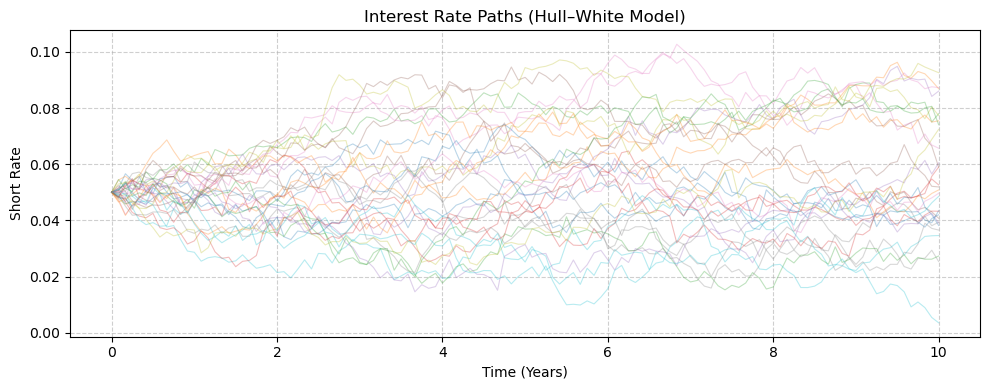

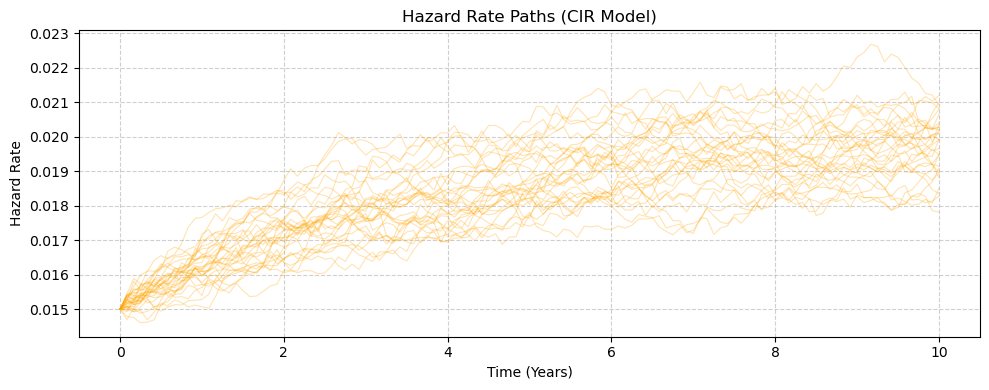

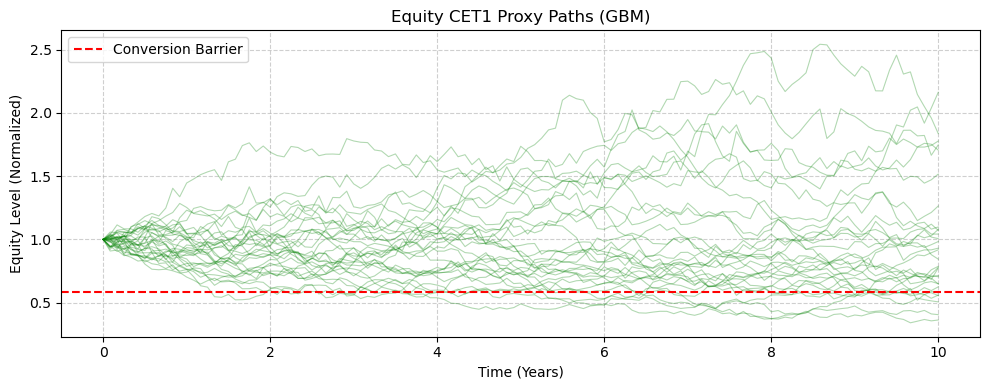


Event Summary:
            count  Probability     mean    std
Event                                         
Alive       29729        0.991   98.188  8.295
Called        134        0.004  119.462  0.439
Conversion    137        0.005   41.728  5.139

Convergence Table:
 Paths    MeanPV
  1000 97.338876
  2000 97.487558
  3000 97.528041
  4000 97.584854
  5000 97.568870
  6000 97.667161
  7000 97.809076
  8000 97.811928
  9000 97.852267
 10000 97.865100
 11000 97.883641
 12000 97.902859
 13000 97.951914
 14000 97.945134
 15000 97.924389
 16000 97.930393
 17000 97.920491
 18000 97.928311
 19000 97.958070
 20000 97.995266
 21000 97.983891
 22000 97.976648
 23000 98.003113
 24000 98.008573
 25000 98.004307
 26000 98.010831
 27000 98.004047
 28000 98.015338
 29000 98.018830
 30000 98.024787


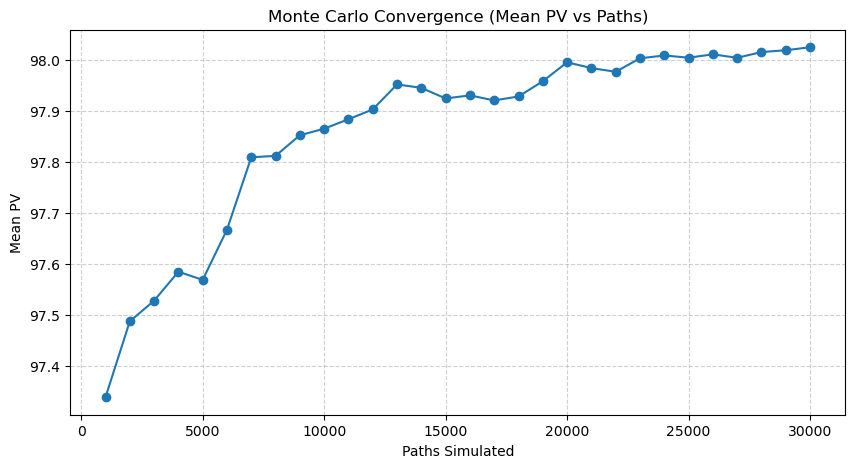

In [11]:
# ============================================================
# MAIN EXECUTION
# ============================================================

# Run Monte Carlo Simulation to Price AT1 Coco Bond
# ----------------------------------------
coco_price, df, rates, hazards, equities = run_simulation(num_paths=30000, use_antithetic=False, show_diagnostics=True)


## Recommended Reading

For further depth on AT1 CoCo bonds and the quantitative methods behind them, the following resources are highly recommended:

1. [Everything You Need to Know About AT1s – Vontobel](https://am.vontobel.com/en/insights/everything-you-need-to-know-about-at1s)  
   A concise and clear overview of AT1 bonds, their features, risks, and market context.

2. *Mathematical Modeling and Computation in Finance* by C. Oosterlee & L. Grzelak  
   A comprehensive textbook covering stochastic models, numerical methods, and option-pricing techniques — useful background for modeling CoCo bonds and embedded contingent features.